In [ ]:
'''
주제/키워드가 주어졌을때 다음을 시각화 한다
1. 구글 트렌드
2. 투자
3. 인수
'''

In [222]:
import pandas as pd
import re
import gensim
import pickle
from datetime import datetime
from matplotlib import pyplot as plt
%matplotlib inline

In [223]:
# load data
data_folder = '../data/csv_export/'
util_folder = '../util/'
trend_folder = '../data/trends/'
df_organizations = pd.read_csv(data_folder + 'organizations.csv'.format(data_folder), dtype={'first_funding_on': str, 'last_funding_on':str})
df_description = pd.read_csv(data_folder + 'organization_descriptions.csv')
df_funding_rounds = pd.read_csv(data_folder + 'funding_rounds.csv')
df_funds = pd.read_csv(data_folder + 'funds.csv')
df_investments = pd.read_csv(data_folder + 'investments.csv')
df_acq = pd.read_csv(data_folder + 'acquisitions.csv')

Index([u'Month', u'Augmented reality: (United States)'], dtype='object')


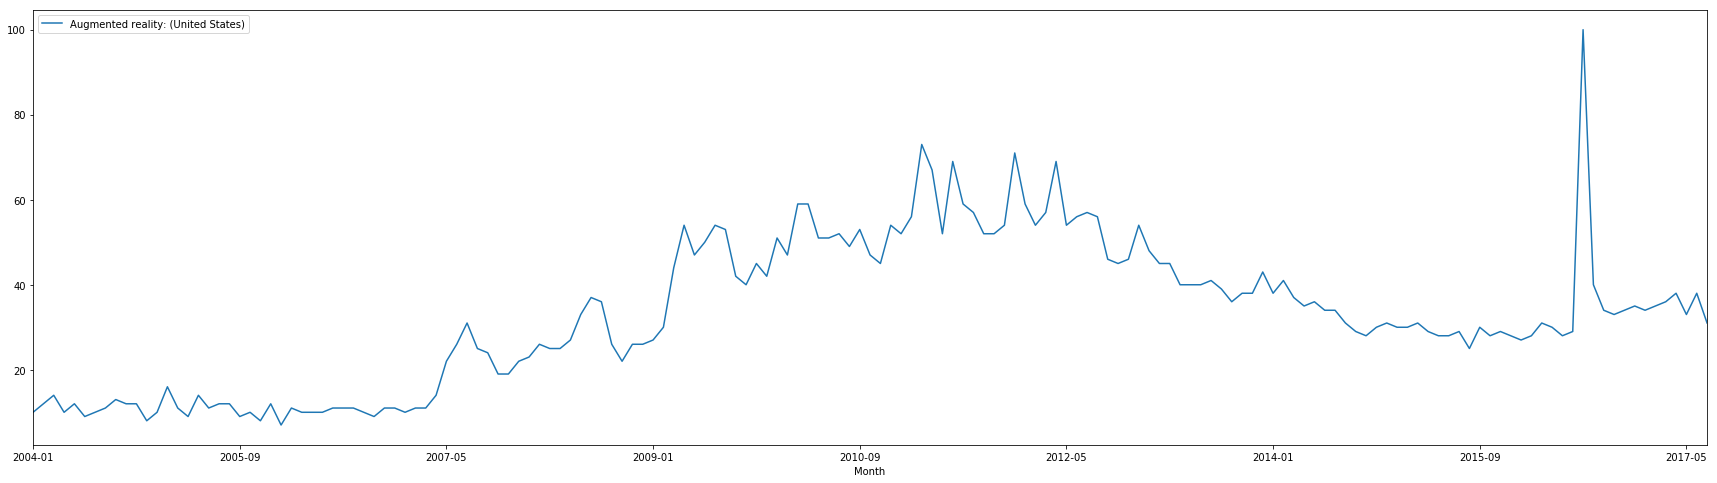

In [21]:
keyword = 'augmented_reality'
df_google_trend = pd.read_csv(trend_folder + keyword + '.csv', header = 1)
print df_google_trend.columns
df_google_trend.plot(kind = 'line', figsize = (30, 8), x = df_google_trend['Month'])
#     df.groupby([df["dates"].dt.year]).count().plot(kind='bar', figsize = (8, 4))

    

In [303]:
def visualize(keyword, words, expand = False):
    fig = plt.figure()
    condition = 'first_funding_on'
    
    f = open(trend_folder + keyword + '.csv')
    df_google_trend = pd.read_csv(trend_folder + keyword + '.csv', header = 1)  
    df_google_trend.columns = ['year-month', 'google_count']
#     df_google_trend.plot(kind = 'line', x = df_google_trend['year-month'], figsize = (30, 8))

    # load required dataset
    if 'word2company' not in globals():
        print('loading word2company')
        global word2company
        word2company = pickle.load(open(util_folder + 'word2company.pickle'))
    if 'model' not in globals():
        print('loading word2vec model')
        global model
        model = gensim.models.word2vec.Word2Vec.load(util_folder + 'word2vec')
        
    # expand word set if necessary
    # train 된 word2vec 을 사용하여 관련도가 높은 단어들을 포함한다
    final_words = []
    if type(words) == str:
        words = [words]
    for word in words:
        if ' ' in word:
            word = word.replace(' ', '_')
        if expand:
            _words = model.most_similar(word)
            _words = [str(_word) for _word, sim in _words]
            final_words.extend(_words)
        final_words.append(word)
    final_words = list(set(final_words))

    # choose companies that have relevant words
    companies = []
    for word in final_words:
        _companies = word2company.get(word, [])
        companies.extend(_companies)
    companies = list(set(companies))

    # 회사를 시기 별로 정리한다
    # 1. funding
    df_companies = df_organizations[df_organizations['uuid'].isin(companies)]
    df = pd.DataFrame()
    df['date'] = df_companies["first_funding_on"]
    df = df[~df['date'].isnull()]
    df['year-month'] = df['date'].str[:7]
    funding = df.groupby(df['year-month']).size().reset_index()
    funding.columns = ['year-month', 'funding_count']
#     funding.plot(kind = 'bar', x = funding['year-month'], figsize = (30, 8))
    
    
    df_merged = pd.merge(df_google_trend, funding, on = 'year-month', how = 'outer')
    
    # 2. acquisition
    df = df_acq[df_acq['acquiree_uuid'].isin(companies)]
    df = df.loc[:,['acquired_on']]
    df['year-month'] = df['acquired_on'].str[:7]
    acq = df.groupby(df['year-month']).size().reset_index()
    acq.columns = ['year-month', 'acq_count']
#     acq.plot(kind = 'bar', x = acq['year-month'], figsize = (30, 8))
    
    df_merged['google_count'] /= 10
    
    df_merged = pd.merge(df_merged, acq, on = 'year-month', how = 'outer')
    ax = df_merged[['year-month', 'google_count']].plot(x = 'year-month', linestyle = '-', color = 'black')
    df_merged[['year-month', 'funding_count', 'acq_count']].plot(x = 'year-month', kind = 'bar', ax = ax, figsize = (30, 8), color = ['red', 'blue'])
    print keyword
    print final_words



augmented_reality
['ar', 'augmented_reality']


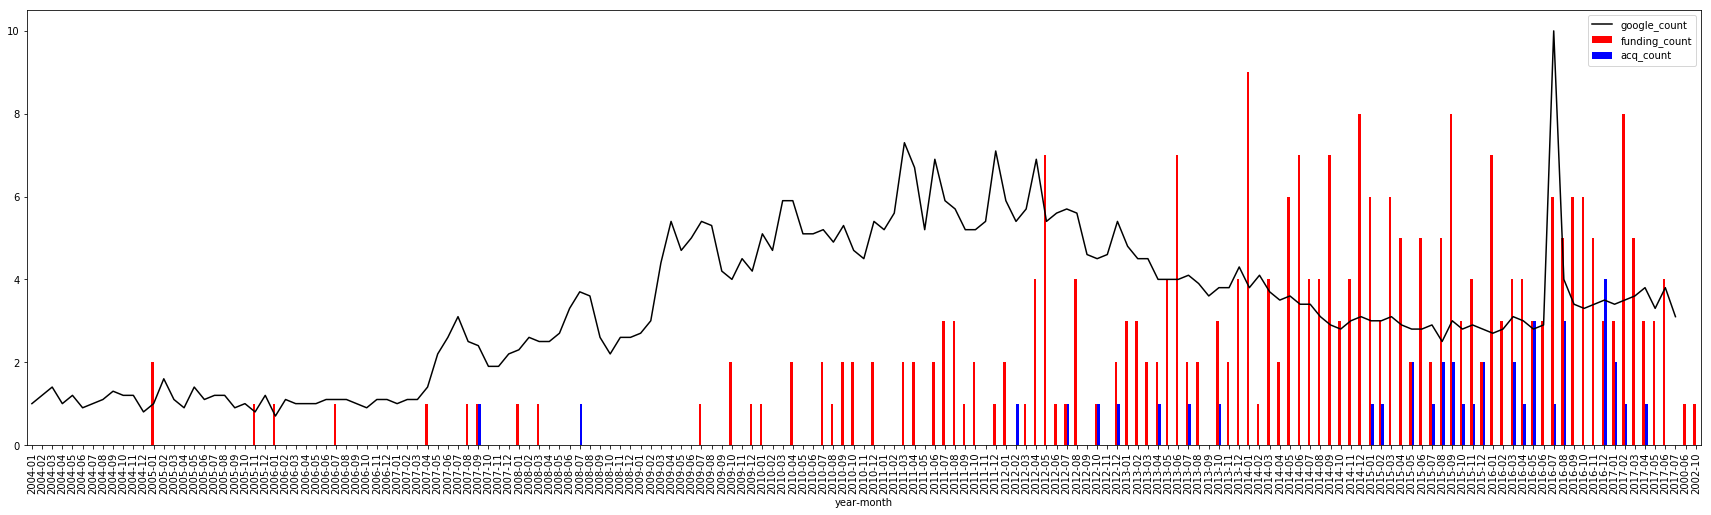

In [306]:
visualize('augmented_reality', ['augmented_reality', 'ar'], expand = False)